# Defs

In [ ]:
import os
import wer
import glob
import time
import math
import pickle
import numpy as np
from tqdm import tqdm
import observation_model
import openfst_python as fst
import matplotlib.pyplot as plt
from subprocess import check_call
from IPython.display import Image


#===============================================================================
# ============================== UTILITY FUNCTIONS =============================
#===============================================================================

def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription


def get_unigram_and_bigram_probs():
    i = 0
    train_split = int(0.5 * len(glob.glob('/group/teaching/asr/labs/recordings/*.wav')))  


    all_transcriptions = ''
    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):   

        transcription = read_transcription(wav_file)
        all_transcriptions += transcription + ' \n'

        i += 1
        if i == train_split:
            break

    # count unigram counts in all_transcriptions
    unigram_counts = {}
    for word in all_transcriptions.replace("\n", " ").split():
        if word in unigram_counts:
            unigram_counts[word] += 1
        else:
            unigram_counts[word] = 1




    unigram_probs = {}
    for word, count in unigram_counts.items():
        unigram_probs[word] = count / sum(unigram_counts.values())


    # save unigram probs to pickle file
    import pickle
    with open('unigram_probs.pickle', 'wb') as handle:
        pickle.dump(unigram_probs, handle)
        # load unigram probs from pickle file
    import pickle
    with open('unigram_probs.pickle', 'rb') as handle:
        unigram_probs = pickle.load(handle)

    # count unigram counts in all_transcriptions
    bigram_counts = {}
    for line in all_transcriptions.split("\n"):
        line = line.split()
        for idx, word in enumerate(line):
            if idx > 0 and (line[idx - 1], word) in bigram_counts:
                bigram_counts[(line[idx - 1], word)] += 1
            elif idx == 0 and ("<start>", word) in bigram_counts:
                bigram_counts[("<start>", word)] += 1
            elif idx == 0 and ("<start>", word) not in bigram_counts:
                bigram_counts[("<start>", word)] = 1
            else:
                bigram_counts[(line[idx - 1], word)] = 1

    # calculate bigram probabilities
    bigram_probs = {}
    for bigram, count in bigram_counts.items():
        if bigram[0] == "<start>":
            bigram_probs[bigram] = count / len(all_transcriptions.split("\n"))
        else:
            bigram_probs[bigram] = count / unigram_counts[bigram[0]]

    return unigram_probs, bigram_probs


def draw(f):
    f.draw('tmp.dot', portrait=True)
    check_call(['dot','-Tpng','-Gdpi=1800','tmp.dot','-o','tmp.png'])
    return Image(filename='tmp.png')


def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex


def generate_symbol_tables(lexicon, n=3, with_silence=True):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))

    if with_silence:
        # add silence symbols
        phone_table.add_symbol('sil')
        for i in range(1,n+1):
            state_table.add_symbol('sil_{}'.format(i))
            
    return word_table, phone_table, state_table

#===============================================================================
# ============================== VITERBI DECODING ==============================
#===============================================================================

class MyViterbiDecoder:
    
    NLL_ZERO = 1e10 
    
    def __init__(self, f, audio_file_name, verbose=False, use_pruning=False, determinized=False, bigram = False, histogram_pruning_threshold = 0):
        """Set up the decoder class with an audio file and WFST f
        """
        self.lex = parse_lexicon('lexicon.txt')
        self.verbose = verbose
        self.om = observation_model.ObservationModel()
        self.f = f
        self.number_of_computiations = 0
        self.decode_time = 0
        self.backtrace_time = 0
        self.use_pruning = use_pruning
        self.prune_threshold = self.NLL_ZERO
        self.determinized = determinized
        self.bigram = bigram
        self.word_start = -1
        self.histogram_pruning_threshold = histogram_pruning_threshold


        for state in self.f.states():
            for arc in self.f.arcs(state):
                o = self.f.output_symbols().find(arc.olabel)
                if o =='sil':
                    self.word_start = arc.nextstate

        if self.word_start == -1:
            if self.determinized:
                self.word_start = 1
                   
                    

        if self.use_pruning:
            self.prune_threshold = 30.0
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        


    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)


    def forward_step(self, t):
        '''
        Propagate the Viterbi costs forward one time step
        '''
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        self.number_of_computiations += 1
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob


                        prob = tp + ep + self.V[t-1][i] # they're logs

                        

                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []

        if self.use_pruning and self.histogram_pruning_threshold == 0:    
            best_path = min(self.V[t])
            for idx, path in enumerate(self.V[t]):
                if path - best_path > self.prune_threshold:
                    self.V[t][idx] = self.NLL_ZERO

        if self.use_pruning and self.histogram_pruning_threshold > 0:
            # get the indices and values of paths in V[t] that do not have NLL_ZERO probability
            indices = [i for i, x in enumerate(self.V[t]) if x != self.NLL_ZERO]
            values = [x for x in self.V[t] if x != self.NLL_ZERO]

            # check if there are more than histogram_threshold paths
            if len(values) > self.histogram_pruning_threshold:
                # keep the histogram_threshold best paths and set the rest to NLL_ZERO
                best_paths = np.argpartition(values, self.histogram_pruning_threshold)[:self.histogram_pruning_threshold]
                for idx in indices:
                    if idx not in best_paths:
                        self.V[t][idx] = self.NLL_ZERO
            
                        
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished and self.verbose:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        start = time.time()
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
            
        self.finalise_decoding()
        end = time.time()
        self.decode_time = end-start
        if self.verbose:
            print("Decoding took", self.decode_time,  "seconds")
            print("Number of computations:", self.number_of_computiations)

    
    def backtrace(self):
        start = time.time()
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state


        next_i = -1
        prev_i = -1

 
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)

            if self.determinized:
            
                if i == self.word_start and self.determinized:
                    best_out_sequence = self.W[t][j] + [0] + best_out_sequence
                else: 
                    best_out_sequence = self.W[t][j] + best_out_sequence                              


            else:
                is_final =  False
                
                if i >=0:
                    for arc in self.f.arcs(i):
                        next_i = arc.nextstate
                        if next_i != i and i != prev_i:
                            if float(self.f.final(next_i)) != math.inf:
                                best_out_sequence = self.W[t][j] + [0] + best_out_sequence
                                is_final = True
                    if not is_final:
                        best_out_sequence = self.W[t][j] + best_out_sequence

                    prev_i = i


            

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        
        best_out_sequence = ' '.join([ self.f.output_symbols().find(label) for label in best_out_sequence])

        if self.bigram:
            split_word = "sil"
        else:
            split_word = "<eps>"

        phones = best_out_sequence.split(split_word)
        phones[0] = phones[0].replace("sil","")
        # print('Phones: ', phones)
        # print('best_out_sequence: ', best_out_sequence)
        # print('best_state_sequence: ', best_state_sequence)
        words = ""

        for phone in phones:
            phone = phone.replace(' ', '')
            for key, val in self.lex.items():
                val = ''.join(val)
                if val == phone:
                    words += key + " "


        end = time.time()
        self.backtrace_time = end-start
        if self.verbose:
            print("Backtrace took", self.backtrace_time, "seconds")
        
        return (best_state_sequence, words)


#===================================================================================================
#======================================  HMM  ======================================================
#===================================================================================================


unigram_probs, bigram_probs = get_unigram_and_bigram_probs()
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)


def generate_phone_wfst(f, start_state, phone, n, sl_prop=0.1, tl_prop=0.9):
    """
    Generate a WFST representating an n-state left-to-right phone HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assmed to exist already
        phone (str): the phone label 
        n (int): number of states for each phone HMM
        
    Returns:
        the final state of the FST
    """


    current_state = start_state
    
    for i in range(1, n+1):
        
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        sl_weight = fst.Weight('tropical', -math.log(sl_prop))  # weight for self-loop
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        if i == n:
            out_label = phone_table.find(phone)
        else:
            out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        next_weight = fst.Weight('tropical', -math.log(tl_prop)) # weight to next state
        f.add_arc(current_state, fst.Arc(in_label, out_label, next_weight, next_state))    
       
        cp = current_state
        current_state = next_state

    return current_state


def generate_word_sequence_recognition_wfst(n, sl_prop=0.1, tl_prop=0.9):
    """ generate a HMM to recognise any single word sequence for words in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst()
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    for word, phones in lex.items():
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
        
        for phone in phones: 
            current_state = generate_phone_wfst(f, current_state, phone, n, sl_prop, tl_prop)
        # note: new current_state is now set to the final state of the previous phone WFST
        
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, 0, None, start_state))
        
    return f


def generate_word_sequence_recognition_wfst_with_silence(n, use_unigram_probs=False, sl_prop=0.1, tl_prop=0.9):
    """ generate a HMM to recognise any single word sequence for words in the lexicon with 2 silence states at the beginning and end
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """



    f = fst.Fst()

    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)

    silence_state = generate_phone_wfst(f, start_state, 'sil', 3, sl_prop, tl_prop)
    i = 0
    for word, phones in lex.items():
        
        
        current_state = f.add_state()
        if use_unigram_probs:
            unigram_weight = fst.Weight('tropical', -math.log(unigram_probs[word]))
        else:
            unigram_weight = None
        f.add_arc(silence_state, fst.Arc(0, 0, unigram_weight , current_state))

        for index, phone in enumerate(phones):

            current_state = generate_phone_wfst(f, current_state, phone, n, sl_prop, tl_prop)
        # note: new current_state is now set to the final state of the previous phone WFST

        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, 0, None, silence_state))



    return f


def generate_bigram_wfst(n):
    """ generate a HMM to recognise any single word sequence for words in the lexicon with 2 silence states at the beginning and end
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """


    f = fst.Fst()

    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    silence_state = generate_phone_wfst(f, start_state, 'sil', 3)



    word_states_dict = {}
    for word, phones in lex.items():
        word_state = f.add_state()
        bigram_start_weight = fst.Weight('tropical', 1e10)
        if ('<start>', word) in bigram_probs:
            bigram_start_weight = fst.Weight('tropical', -math.log(bigram_probs[('<start>',word)]))

        f.add_arc(silence_state, fst.Arc(0, 0, bigram_start_weight, word_state))
        word_states_dict[word] = word_state
        f.set_final(word_state)
        
    for key, value in word_states_dict.items():
        for word, phones in lex.items():
            current_state = f.add_state()


            bigram_weight = fst.Weight('tropical', 1e10)
            
            if (key, word)  in bigram_probs:
                bigram_weight = fst.Weight('tropical', -math.log(bigram_probs[(key,word)]))

            f.add_arc(value, fst.Arc(0, 0, bigram_weight, current_state))
            for index, phone in enumerate(phones):

                current_state = generate_phone_wfst(f, current_state, phone, n)
            
            silence_state = generate_phone_wfst(f, current_state, 'sil', 3)

            f.add_arc(silence_state, fst.Arc(0, 0, None, word_states_dict[word]))
    return f


#==============================================================================
#========================== Set up the Experiment =============================
#==============================================================================

def create_wfst(n):
    f = generate_word_sequence_recognition_wfst(n)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f


def create_tuned_wfst(n):
    f = generate_word_sequence_recognition_wfst_with_silence(n, sl_prop=0.95, tl_prop=0.05)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f


def create_wfst_with_silence(n, use_unigram_probs=False):
    f = generate_word_sequence_recognition_wfst_with_silence(n, use_unigram_probs=use_unigram_probs)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f


def create_bigram_lexical(n):
    f = generate_bigram_wfst(n)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f


def memory_of_wfst(f):
    '''
    Compute a measure of the memory required for your decoder by providing counts
    of number of states and arcs in the WFST.
    '''
    all_states = []
    all_arcs = []
    for state in f.states():
        all_states.append(state)
        for arc in f.arcs(state):
            all_arcs.append(arc)
    return len(all_states), len(all_arcs)

    
def get_avg_wer(all_losses, verbose=False):
    all_wer = []
    for error_counts, word_count in all_losses:
        all_wer.append(sum(error_counts) / word_count)
    
    if verbose :
        print(f'The average WER is {np.mean(all_wer):.2%}')    
    return np.mean(all_wer)


def get_avg_effciency(efficancy_measures, verbose=False):
    decoding_time = np.mean(efficancy_measures[0])
    backtrace_time = np.mean(efficancy_measures[1])
    number_of_computions = np.mean(efficancy_measures[2])
    if verbose:
        print(f'The average decoding time is {decoding_time:.2f} seconds')
        print(f'The average backtrace time is {backtrace_time:.2f} seconds')
        print(f'The average number of computations is {number_of_computions:.2f}')
    return decoding_time, backtrace_time, number_of_computions


def decoding_loop(f, train_set=True, train_split=0.5, use_pruning=False, determinized=False, verbose=False, prune_threshold= None, bigram = False, histogram_pruning_threshold = 0):
    all_losses = []
    decoding_time = []
    backtrace_time = []
    number_of_computations = []
    all_files = glob.glob('/group/teaching/asr/labs/recordings/*.wav')
    train_files = all_files[:(int(train_split*len(all_files)))]
    test_files = all_files[(int(train_split*len(all_files))):]
    
    if train_set:
        files= train_files
    else:
        files = test_files
    
    for wav_file in tqdm(files):    
        decoder  = MyViterbiDecoder(f, wav_file, verbose=verbose, use_pruning=use_pruning, determinized=determinized, bigram=bigram, histogram_pruning_threshold=histogram_pruning_threshold)
        if use_pruning and prune_threshold!=None:
            decoder.prune_threshold = prune_threshold
        decoder.decode()
        (state_path, words) = decoder.backtrace()  
        transcription = read_transcription(wav_file)
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        all_losses.append((error_counts, word_count))
        decoding_time.append(decoder.decode_time)
        backtrace_time.append(decoder.backtrace_time)
        number_of_computations.append(decoder.number_of_computiations)
        if verbose:
            print(f'Transcription: {transcription} || Prediction: {words} || (nsub, ndel, nin) :{error_counts}')
    
    efficancy_measures = (decoding_time, backtrace_time, number_of_computations)
    return all_losses, efficancy_measures


# Results

In [ ]:
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)
n = 3
f = create_wfst(n)
f_silence = create_wfst_with_silence(n)
f_bigram = create_bigram_lexical(n)
f_det = fst.determinize(f)
f_silence_det = fst.determinize(f_silence)
f_bigram_det = fst.determinize(f_bigram)
f_det_min = f_det.copy()
f_det_min.minimize(allow_nondet = True)
f_silence_det_min = f_silence_det.copy()
f_silence_det_min.minimize(allow_nondet = True)
f_bigram_det_min = f_bigram_det.copy()
f_bigram_det_min.minimize(allow_nondet = True)
f_tuned = create_tuned_wfst(n)
f_tuned_det = fst.determinize(f_tuned)
f_tuned_det_min = f_tuned_det.copy()
f_tuned_det_min.minimize(allow_nondet = True)
print('Created all the wfst')

def run_exp(exp_dict ,wfst_type, det, train_set = True ,train_split = 0.5, verbose=False, use_pruning=False, prune_threshold=None, histogram_pruning_threshold=0, minimized=False):
    wfsts = {'baseline': f, 'silence': f_silence, 'bigram': f_bigram, 'tuned': f_tuned}
    wfsts_det = {'baseline': f_det, 'silence': f_silence_det, 'bigram': f_bigram_det, 'tuned': f_tuned_det}
    wfsts_det_min = {'baseline': f_det_min, 'silence': f_silence_det_min, 'bigram': f_bigram_det_min, 'tuned': f_tuned_det_min}

    if minimized:
        wfst = wfsts_det_min[wfst_type]
    elif det:
        wfst = wfsts_det[wfst_type]
    else:
        wfst = wfsts[wfst_type]
    bigram = False
    if wfst_type == 'bigram':
        bigram = True
    
    exp_dict['type'] = wfst_type
    exp_dict['det'] = det
    exp_dict['all_states'], exp_dict['all_arcs'] = memory_of_wfst(wfst)

    print(f'Type {wfst_type}, det = {det}, minimized = {minimized}')
    print(f'All states: {exp_dict["all_states"]}, all arcs: {exp_dict["all_arcs"]}')


    all_losses, efficancy_measures = decoding_loop(wfst, train_set=train_set, train_split=train_split, determinized=det, verbose=verbose, bigram=bigram, use_pruning=use_pruning, prune_threshold=prune_threshold, histogram_pruning_threshold=histogram_pruning_threshold)
    avg_wer = get_avg_wer(all_losses, verbose=True)
    m1,m2,m3 = get_avg_effciency(efficancy_measures, verbose=verbose)
    exp_dict['loss'].append(all_losses)
    exp_dict['efficancy'].append(efficancy_measures)
    exp_dict['acc'].append(avg_wer)
    exp_dict['m1'].append(m1)
    exp_dict['m2'].append(m2)
    exp_dict['m3'].append(m3)
    print('\n\n\n')
    return exp_dict, wfst




In [ ]:
exp_dict= {
    'loss' : [],
    'efficancy':[],
    'acc': [],
    'm1': [],
    'm2': [],
    'm3': [],
    'all_states': [],
    'all_arcs': [],
    'det': False,
    'type': 'baseline'   
}



prune_thresholds = [i*5 for i in range(1,21)]
det = False
wfst_type = 'tuned'
verbose = False
size = 0.5

for prune_threshold in prune_thresholds:
    print(f'Threshold = {prune_threshold}')
    exp_dict, wfst = run_exp(exp_dict, wfst_type, det, verbose=verbose, train_split=size, use_pruning=True, prune_threshold=prune_threshold)
    exp_dict['WFST'] = wfst

    file_name = f'exp_dict_tuned_ours_{prune_threshold}.pkl'
    with open(file_name, 'wb') as handler:
        pickle.dump(exp_dict, handler)
    print(f'saved to {file_name}')


In [ ]:
# print the experiment results
print(f'FST type: {exp_dict["type"]}')
print(f'Determinized: {exp_dict["det"]}')
print(f'All states: {exp_dict["all_states"]}, all arcs: {exp_dict["all_arcs"]}')
print(f'WER: {exp_dict["acc"]}')
print(f'M1 (avg. Decoding time): {exp_dict["m1"]}')
print(f'M2 (avg. Backtrace time): {exp_dict["m2"]}')
print(f'M3 (avg. Number of Computations): {exp_dict["m3"]}')

draw(wfst)

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

# use figure size (width, height) in inches
plt.figure(figsize=(10, 5))

# create a plot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot the first subplot
ax1.plot(prune_thresholds, exp_dict['acc'], 'o-')
ax1.set_title('WER')
ax1.set_xlabel('Prune Threshold')
ax1.set_ylabel('WER')

# plot the second subplot
ax2.plot(prune_thresholds, exp_dict['m1'], 'o-')
ax2.set_title('Decoding Time')
ax2.set_xlabel('Prune Threshold')
ax2.set_ylabel('Decoding Time')

plt.show()

In [13]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt


file_name_baseline_ours = 'exp_dict_baseline_ours_100.pkl'
file_name_baseline_histogram = 'exp_dict_baseline_histogram_200.pkl'
file_name_tuned_ours = 'exp_dict_tuned_ours_100.pkl'
file_name_tuned_histogram = 'exp_dict_tuned_histogram_200.pkl'

with open(file_name_baseline_ours, 'rb') as handler:
    exp_dict_baseline_ours = pickle.load(handler)

with open(file_name_baseline_histogram, 'rb') as handler:
    exp_dict_baseline_histogram = pickle.load(handler)

# with open(file_name_tuned_ours, 'rb') as handler:
#     exp_dict_tuned_ours = pickle.load(handler)

# with open(file_name_tuned_histogram, 'rb') as handler:
#     exp_dict_tuned_histogram = pickle.load(handler)

current_exp_dict = exp_dict_baseline_ours
prune_thresholds = [i*5 for i in range(1,21)]

# current_exp_dict = exp_dict_baseline_histogram
# prune_thresholds = [i*10 for i in range(1,21)]


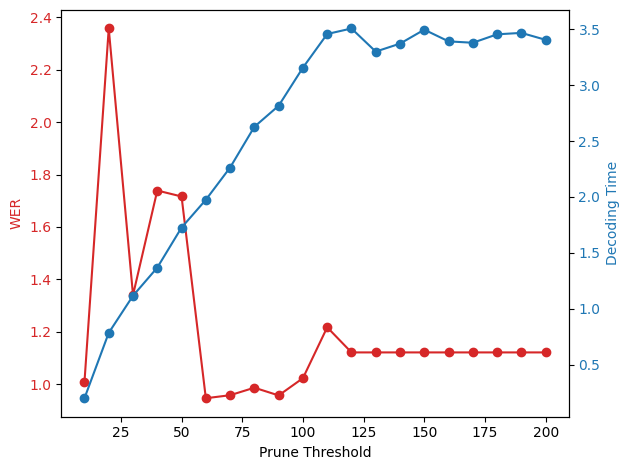

In [10]:

# plot the accuracy and decoding time vs prune threshold in the same plot with two y axes
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Prune Threshold')
ax1.set_ylabel('WER', color=color)
ax1.plot(prune_thresholds, current_exp_dict['acc'], 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Decoding Time', color=color)  # we already handled the x-label with ax1
ax2.plot(prune_thresholds, current_exp_dict['m1'], 'o-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [12]:
# get the best prune threshold
best_prune_threshold = prune_thresholds[np.argmin(current_exp_dict['acc'])]
print(f'Best prune threshold: {best_prune_threshold}')
print(f'WER: {current_exp_dict["acc"][np.argmin(current_exp_dict["acc"])]}')
print(f'Decoding Time: {current_exp_dict["m1"][np.argmin(current_exp_dict["acc"])]}')

Best prune threshold: 60
WER: 0.9468420170695419
Decoding Time: 1.9748745759328206


In [15]:
# get the best prune threshold
best_prune_threshold = prune_thresholds[np.argmin(current_exp_dict['acc'])]
print(f'Best prune threshold: {best_prune_threshold}')
print(f'WER: {current_exp_dict["acc"][np.argmin(current_exp_dict["acc"])]}')
print(f'Decoding Time: {current_exp_dict["m1"][np.argmin(current_exp_dict["acc"])]}')

Best prune threshold: 45
WER: 1.1190777447159246
Decoding Time: 2.673582577855332
